# Welcome to Week 1: Triangulation!
This week, we are focusing on the concepts behind triangulation. In the theory part, you learned about the baseline, the focal length, the disparity, and you got a general process to estimate the depth. In the assignment, I'd like you to work with you group to try and understand how to build a depth map.

## $\color{#DD5566}{\text{TODO: Assignment Progress}}$
* [ ] Load images
* [ ] Implement the disparity_estimator function with StereoBM or StereoSGBM.
* [ ] **Squad Assignment:** Publish one HORRIBLE Disparity Map to your Squad Group, and explain WHY it's terrible.
* [ ] Implement the Disparity to Depth functions and visualize the depth map
* [ ] The Extra 20% (Optional): Complete the Outstanding Points Section
<p>👉🏼 For the group assignment, we don't want good looking ones, we want to understand why a disparity map does not work. You can screenshot code, error blocks, wrong parameters, ANYTHING you noticed made the solution fail. Let's see who has the worst one!

We will go through a workshop in 3 core steps:


1.   **Load the images.**<p>
There are 4 images: 3 coming from the KITTI VISION BENCHMARK SUITE and 1 coming from my own Stereo Camera.

2.   **Create a Disparity Map**<P>
Use the algorithms we've learned such as Stereo BM and Stereo SGBM to try and build a disparity map!

3.   **Compute the Depth Map**<p>
Use these matrices and the disparity to build a depth map.

Next week, we'll move closer to practical applications of this, and build a 3D Point Cloud, as well as an Object Detection pipeline. For now, let's focus on the depth map.

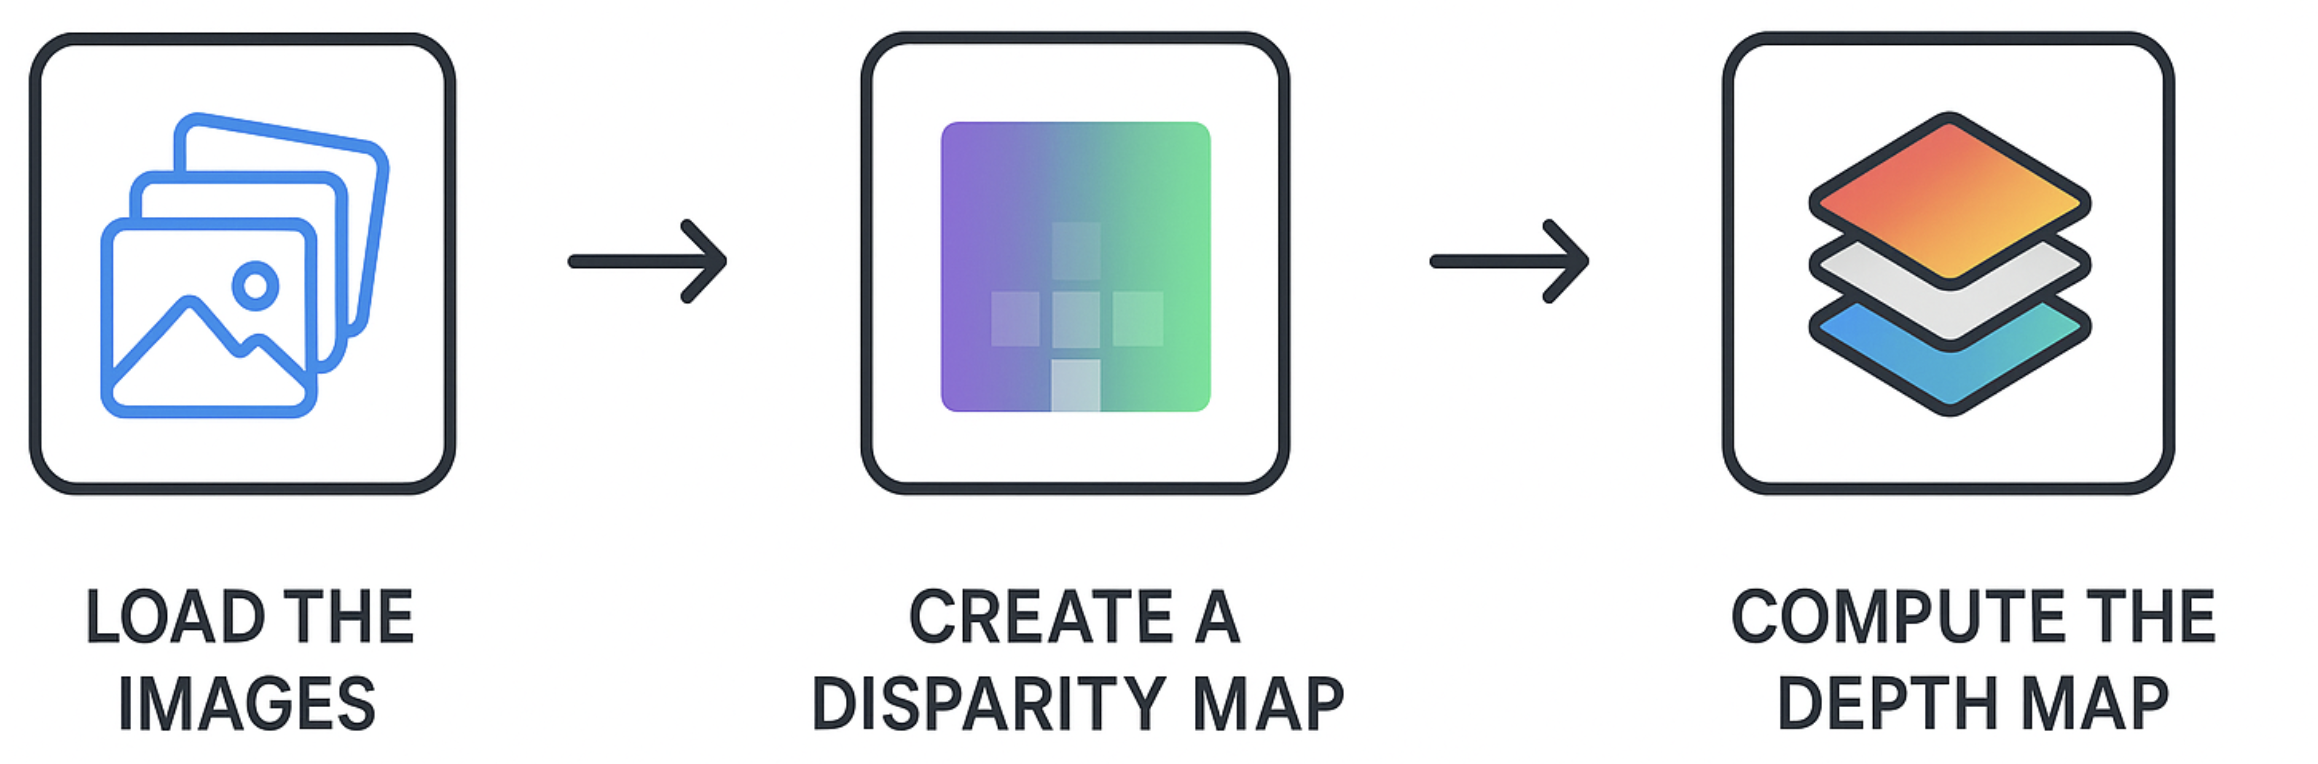

## 1) **Load the Images**
We'll begin simply by loading the images. To load the images, you can use the "wget" command line, which will get everything ready for you.

In [ ]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_data.zip

In [ ]:
!unzip -q stereo_data.zip

In [1]:
import os
os.chdir("stereo_data")

### Additional Libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import glob

### Load image data

There are 6 images


Text(0.5, 1.0, 'Image Right')

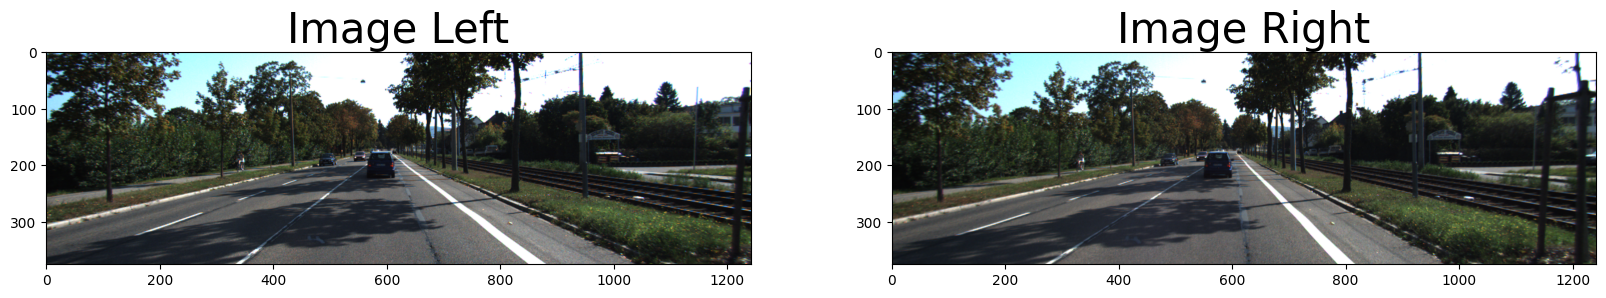

In [3]:
images_L = sorted(glob.glob("left/*.png"))
images_R = sorted(glob.glob("right/*.png"))
labels = sorted(glob.glob("labels/*.txt"))
calib_files = sorted(glob.glob("calib/*.txt"))

print("There are",len(images_L),"images")
index = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(cv2.imread(images_L[index]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image Left', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(images_R[index]), cv2.COLOR_BGR2RGB))
ax2.set_title('Image Right', fontsize=30)

### Dataset Questions
We are extracting these images from the KITTI dataset, therefore, all the data is public. Assuming we'll need this later, can you figure out...
* What is the baseline?
* What is the focal length?
To help you, you can read more about the setup used here: https://www.cvlibs.net/datasets/kitti/setup.php

# 2 - **Calculate the Disparity Map**
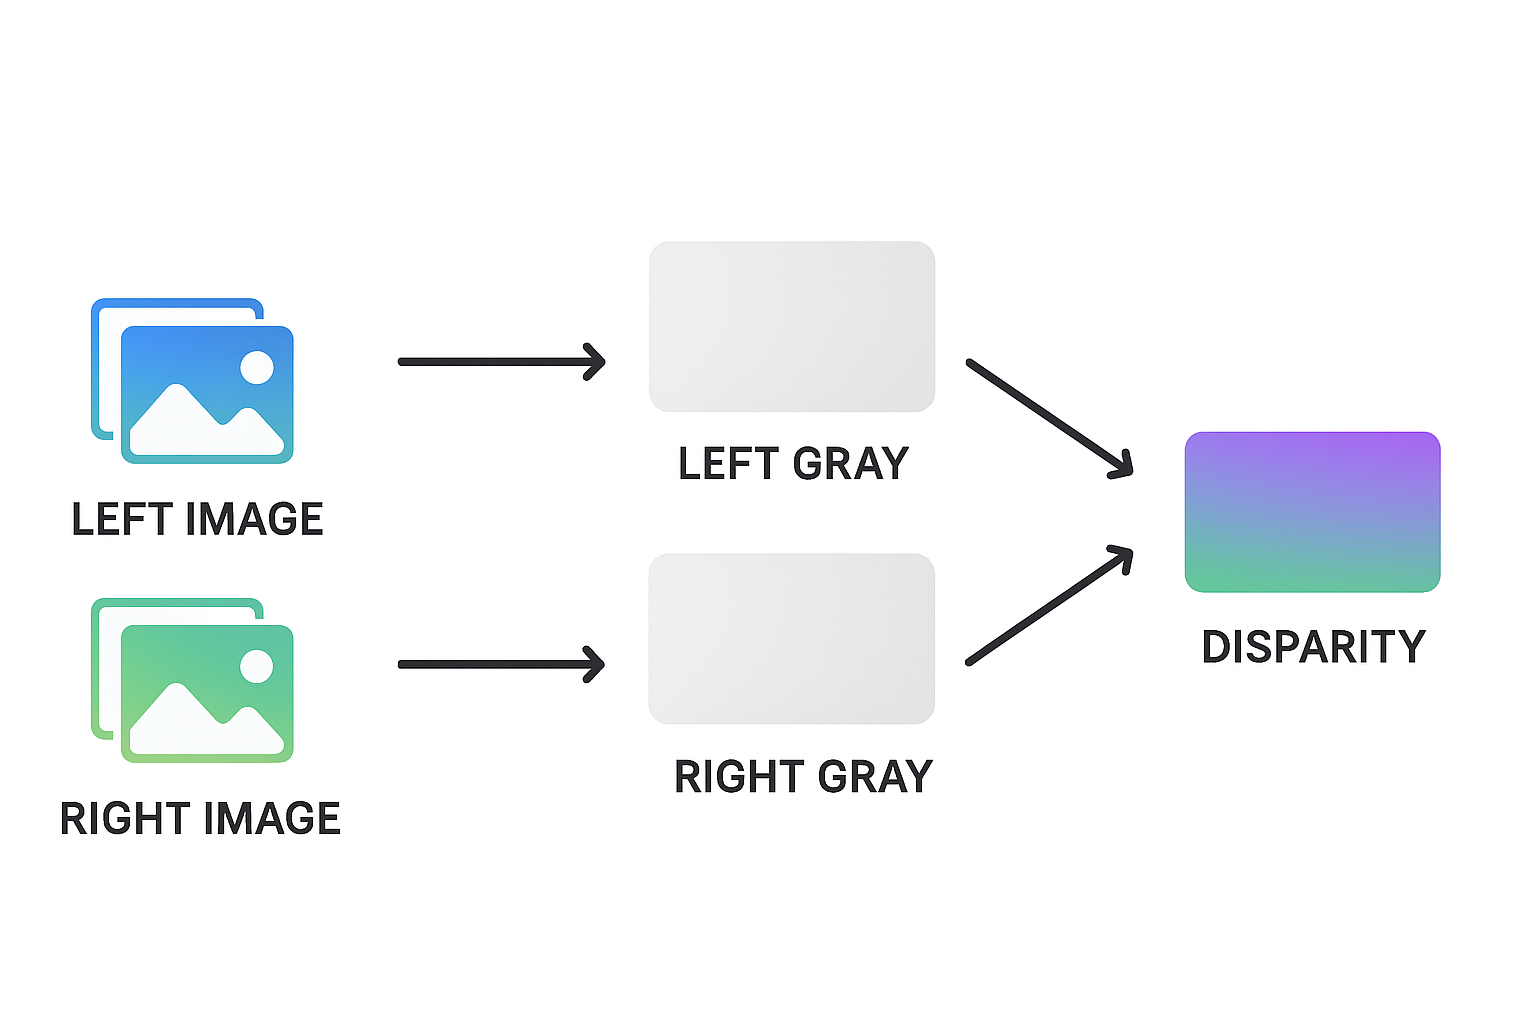

### Basic Disparity Estimation
There are 2 very simple OpenCV algorithms we can use for disparity estimation called StereoBM and StereoSGBM. Next week, you'll go in the details of how these work, but for now, I'd like you to simply try and use them.
* BM stands for Block Matching
* SGBM stands for Semi-Global Block Matching

In [4]:
def disparity_estimator(img_l_path, img_r_path):
    # Read the images
    image_left = cv2.imread(img_l_path)
    image_right = cv2.imread(img_r_path)

    # Convert the images to grayscale
    img_left_gray = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)

    # Experiment with disparities & block size
    num_disparities = 16*6 #96
    block_size = 5+2*2 #5

    #Create a Block Matcher and Compute the disparity
    stereo = cv2.StereoBM_create(num_disparities, block_size)
    disparity = stereo.compute(img_left_gray, img_right_gray)
    # new_image = #TODO: Call StereoBM with the right parameters!
    # new_image = #TODO: Call the new_image.compute(left, right) function

    #Visualize it
    plt.imshow(disparity, cmap="cividis")
    plt.show()

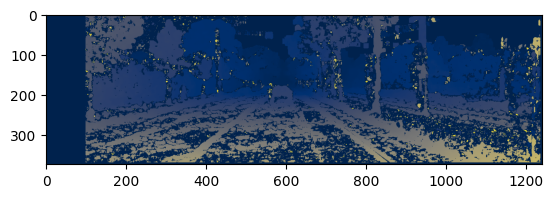

In [5]:
disparity_estimator(images_L[0], images_R[0])

## Compute And Display the Disparity

In [6]:
def compute_disparity(image_left, image_right, num_disparities=6*16, block_size=11, window_size=6, matcher="stereo_sgbm", show_disparity=True):
    """
    Create a Stereo BM or Stereo SGBM Matcher
    Compute the Matching
    Display the disparity image
    Return it
    """
    if matcher == "stereo_bm":
        block_matching_obj = cv2.StereoBM_create(num_disparities, block_size)
    elif matcher == "stereo_sgbm":
        '''
        Understand parameters: https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html
        '''
        block_matching_obj = cv2.StereoSGBM_create(
            minDisparity=0,
            numDisparities=num_disparities,
            blockSize=block_size,
            speckleWindowSize=window_size)


    disparity = block_matching_obj.compute(image_left, image_right)
    if (show_disparity==True):
        plt.figure(figsize = (40,20))
        plt.imshow(disparity, cmap="cividis")
        plt.show()
    return disparity

In [7]:
"""
NUM_DISPARITIES:
the disparity search range.
For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities.
The search range can then be shifted by changing the minimum disparity.
--> The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
"""
num_d = (0,512,16)

"""
BLOCK SIZE: the linear size of the blocks compared by the algorithm.
Matched block size. It must be an odd number >=1 .
Normally, it should be somewhere in the 3..11 range.
--> Larger block size implies smoother, though less accurate disparity map.
--> Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.
"""
b_s = (1,19,2)

"""
WINDOW SIZE:
Default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
"""
window_s = (1,13,2)

"""
MIN DISPARITY
min: Minimum possible disparity value.
Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
max: has to be dividable by 16 f. E. HH 192, 256, default:
#
"""

'\nMIN DISPARITY\nmin: Minimum possible disparity value.\nNormally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.\nmax: has to be dividable by 16 f. E. HH 192, 256, default:\n#\n'

In [8]:
#Reading the Left Images
img_left = cv2.imread(images_L[index]) #OpenCV reads in BGR
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
# Reading the right Images
img_right = cv2.imread(images_R[index]) #OpenCV reads in BGR
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

In [9]:
disparity_left = interactive(compute_disparity, image_left=fixed(img_left_gray), image_right = fixed(img_right_gray), num_disparities=num_d, block_size=b_s, window_size=window_s, matcher=["stereo_sgbm", "stereo_bm"])
display(disparity_left)

interactive(children=(IntSlider(value=96, description='num_disparities', max=512, step=16), IntSlider(value=11…

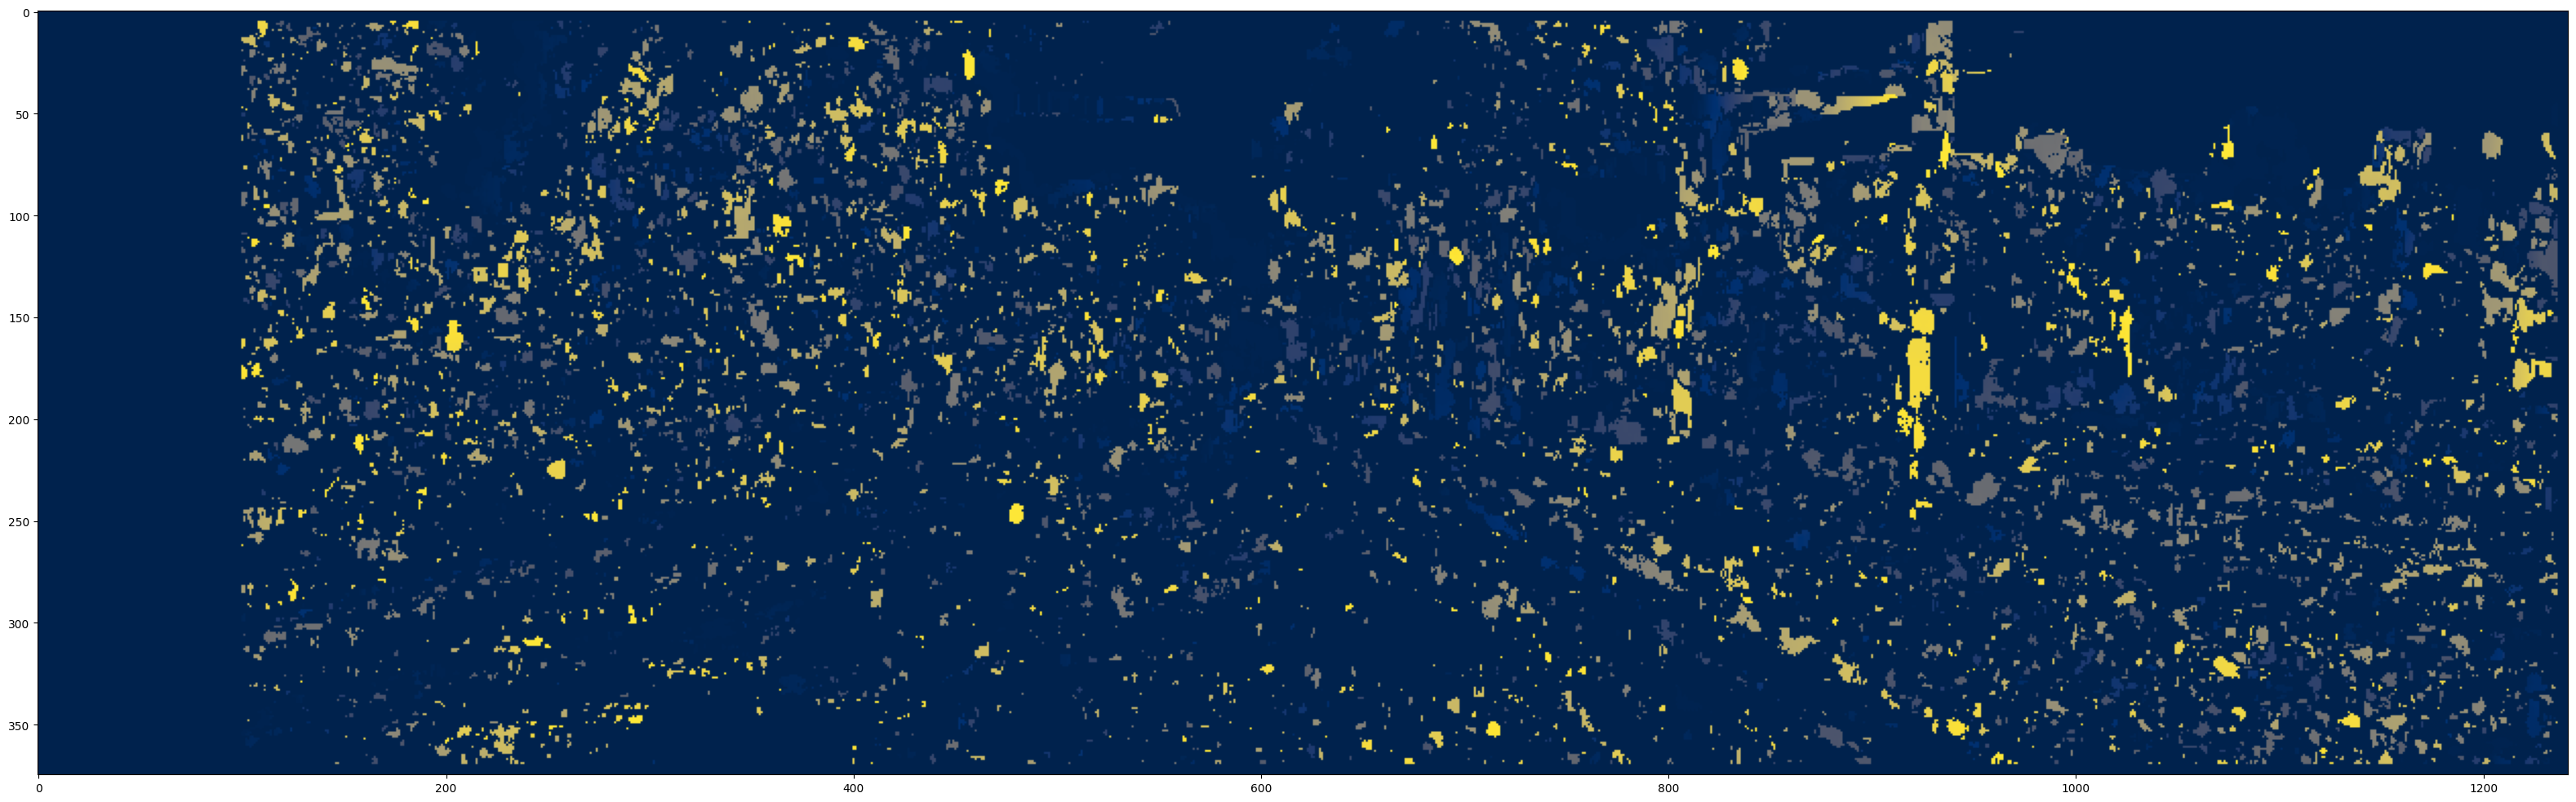

In [10]:
disparity_right_img = compute_disparity(img_right_gray, image_right=img_left_gray, num_disparities=disparity_left.kwargs["num_disparities"], block_size=disparity_left.kwargs["block_size"], window_size=disparity_left.kwargs["window_size"], matcher=disparity_left.kwargs["matcher"])

max, min =  1520 -16
max, min =  1520 -16


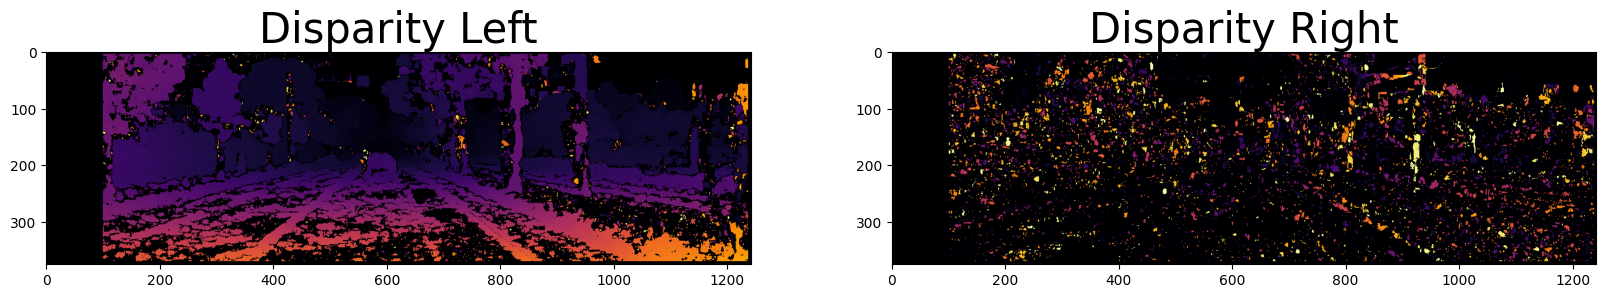

In [12]:
disparity_left_img = disparity_left.result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(disparity_left_img,  cmap="inferno") # or CMRmap_r
ax1.set_title('Disparity Left', fontsize=30)
ax2.imshow(disparity_right_img, cmap="inferno")
ax2.set_title('Disparity Right', fontsize=30)

print("max, min = ", np.max(disparity_left_img), np.min(disparity_left_img))
print("max, min = ", np.max(disparity_right_img), np.min(disparity_right_img))

#cv2.imwrite("output/disparity.png",disparity_left)

### Analysis, what is a disparity map?

[[ 94  94  93 ... 172 -16 -16]
 [ 94  94  93 ... 171 -16 -16]
 [ 95  95  93 ... 170 -16 -16]
 ...
 [385 383 379 ... 377 377 377]
 [390 389 383 ... 380 381 381]
 [393 391 388 ... 389 390 389]]
[[ 94  94  93 ... 172   0   0]
 [ 94  94  93 ... 171   0   0]
 [ 95  95  93 ... 170   0   0]
 ...
 [385 383 379 ... 377 377 377]
 [390 389 383 ... 380 381 381]
 [393 391 388 ... 389 390 389]]


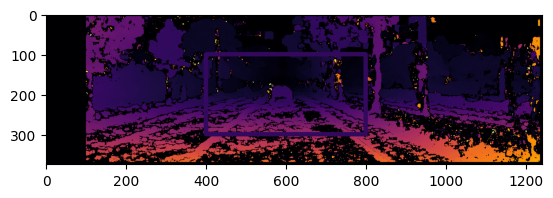

In [27]:
squared = disparity_left_img.copy()
squared[squared <= 0] = 0

cv2.rectangle(squared, pt1=(400,100), pt2=(800,300), color=(255,0,0), thickness=10)
plt.imshow(squared, cmap="inferno")

print(disparity_left_img[150:250, 500:700])
print(squared[150:250, 500:700])

The disparity map is the size of the image.<p>
At the location of each pixel, you get the distance in pixel to travel to get the correspondance in the other image.<p>

*   Objects that are far away are smaller in pixels, and the disparity value will be lower
*   Close objects will appear at different angles and thus need a higher disparity value



**From now on, we'll only focus on the image "disparity left".**

# Step 3 - **Compute Depth Map**
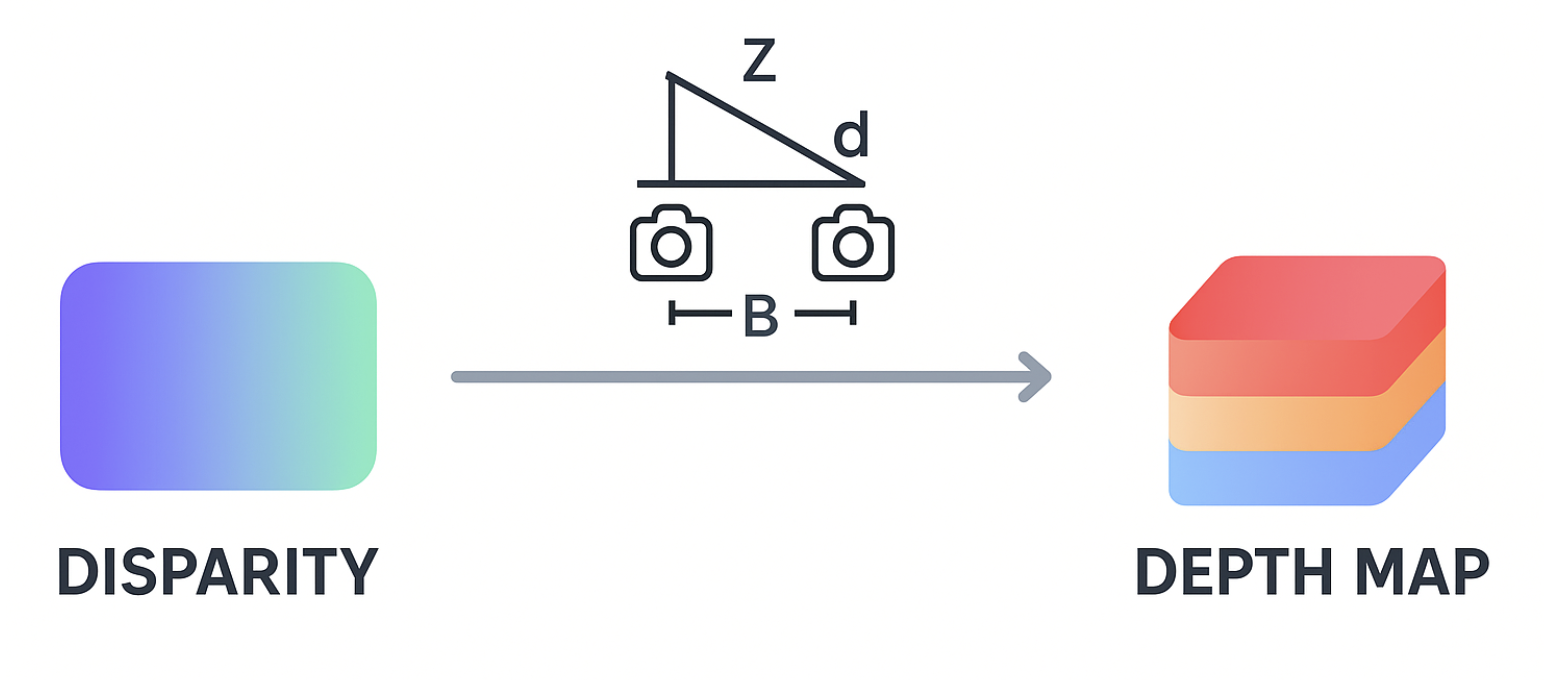

### Get Calibration Parameters

In [21]:
print("Calibration file for image: ", open(calib_files[index]))
print(open(calib_files[index]).read())

Calibration file for image:  <_io.TextIOWrapper name='calib/000007.txt' mode='r' encoding='UTF-8'>
P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.0000000

The following lines will help us parse the dataset to collect desired information.

Note: We are skipping P0 and P1 as they represent grayscale data.

In [22]:
# Original
def get_calibration_parameters(file):
    with open(file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == 'P2':
                p_left = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:2] == 'P3':
                p_right = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:7] == 'R0_rect':
                p_ro_rect = np.array(line[9:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_velo_to_cam':
                p_velo_to_cam = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_imu_to_velo':
                p_imu_to_velo = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
    return p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo

p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

np.set_printoptions(precision=5)
print("Left P Matrix")
print(p_left)
print("Right P Matrix")
print(p_right)
print("RO to Rect Matrix")
print(p_ro_rect)
print("Velodyne to Camera Matrix")
print(p_velo_to_cam)
print("IMU to Velodyne Matrix")
print(p_imu_to_velo)

Left P Matrix
[[7.21538e+02 0.00000e+00 6.09559e+02 4.48573e+01]
 [0.00000e+00 7.21538e+02 1.72854e+02 2.16379e-01]
 [0.00000e+00 0.00000e+00 1.00000e+00 2.74588e-03]]
Right P Matrix
[[ 7.21538e+02  0.00000e+00  6.09559e+02 -3.39524e+02]
 [ 0.00000e+00  7.21538e+02  1.72854e+02  2.19994e+00]
 [ 0.00000e+00  0.00000e+00  1.00000e+00  2.72991e-03]]
RO to Rect Matrix
[[ 0.99992  0.00984 -0.00745]
 [-0.00987  0.99994 -0.00428]
 [ 0.0074   0.00435  0.99996]]
Velodyne to Camera Matrix
[[ 7.53374e-03 -9.99971e-01 -6.16602e-04 -4.06977e-03]
 [ 1.48025e-02  7.28073e-04 -9.99890e-01 -7.63162e-02]
 [ 9.99862e-01  7.52379e-03  1.48076e-02 -2.71781e-01]]
IMU to Velodyne Matrix
[[ 9.99998e-01  7.55307e-04 -2.03583e-03 -8.08676e-01]
 [-7.85403e-04  9.99890e-01 -1.48230e-02  3.19556e-01]
 [ 2.02441e-03  1.48245e-02  9.99888e-01 -7.99723e-01]]


### Compute Depth from Disparity



**So how do we compute the Depth from the disparity? Going back to the class, we remember this formula:**

From our formulas, we defined the following:
![](https://miro.medium.com/max/1152/0*jToKsSZEjNhKaV9S.png) <p>

Awesome! So how do we get F and B? Should we make it up? <p>
Not exactly...

**Actually, this value can be found in P, the matrix you just calculated!**




Let me show you the value of P, according to the KITTI Dataset paper:

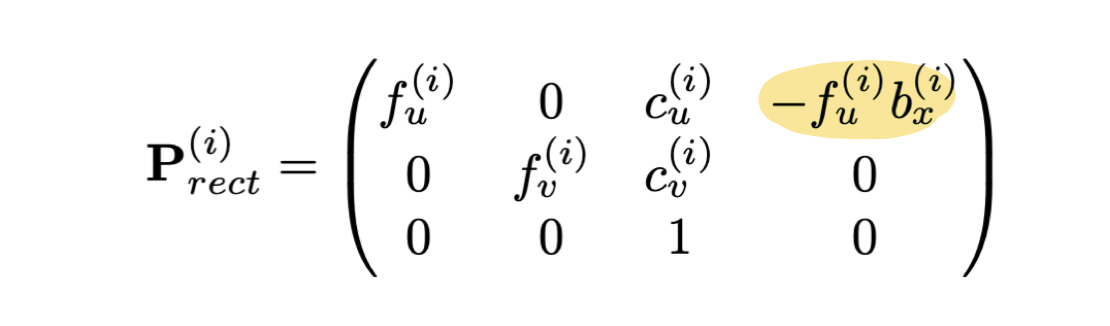

Okay, now, if you scroll up just a bit, you will see the P value we have for left and right!!!

**Don't you see it? We have f*b in P!** It's burried within P! But if you notice, P left and P right don't have the same top right value...
* P_left has 4.48
* P_right has -339.5 🤪

So, which one to use?

Well, neither! And to explain, let me show you this graph:
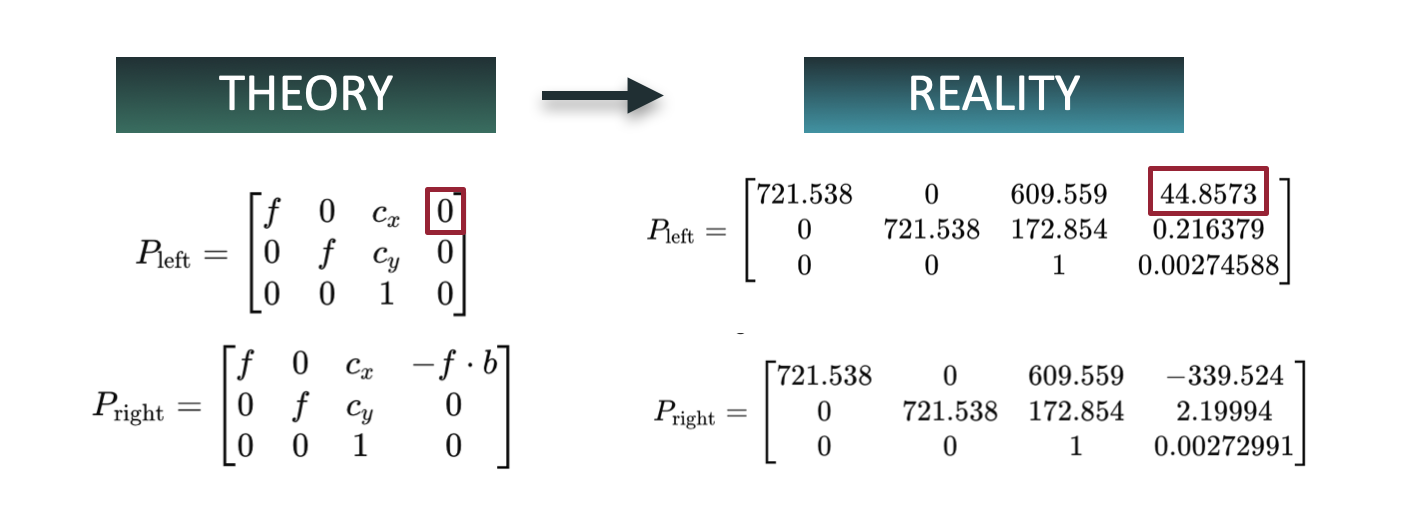

See? We are supposed to use **-f*b** in P_right, but **ONLY** if the P_left top right value is 0. In this case, the calibration that happened shifted this, so we are going to use this value, but subtract with the actual top right corner value we have (44.8).

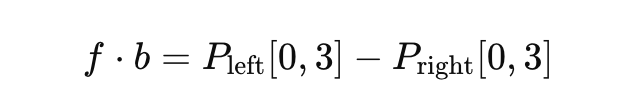

👉🏼 Value to use: f*b = -339.524-44.8573= **384,38**

From there, you can already calculate the baseline, with the formula b = 384/721 ~0.53 (in KITTI setup, you can see 0.54).

But let's not get lost too much here...

In [23]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p) #TODO: Call the decompose function (OpenCV)
    t = t / t[3] # Back from homogeneous
    return k, r, t

# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left) #TODO: Call the decompose function
k_right, r_right, t_right = decompose_projection_matrix(p_right) #TODO: Call the decompose function

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[721.53772   0.      609.55933]
 [  0.      721.53772 172.854  ]
 [  0.        0.        1.     ]]

r_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left 
 [[-5.98493e-02]
 [ 3.57927e-04]
 [-2.74588e-03]
 [ 1.00000e+00]]

k_right 
 [[721.53772   0.      609.55933]
 [  0.      721.53772 172.854  ]
 [  0.        0.        1.     ]]

r_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right 
 [[ 0.47286]
 [-0.00239]
 [-0.00273]
 [ 1.     ]]


In [29]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    disparity = disp_left.copy()
    # Get the focal length from the K matrix
    f = k_left[0,0] #TODO

    # Get the distance between the cameras from the t matrices (baseline)
    b = np.linalg.norm(t_left - t_right) #TODO #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)

    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity[disparity <= 0] = 0.1
    disparity[disparity == -1] = 0.1
    
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disparity.shape, np.single)
    
    # Calculate the depths
    depth_map[:] =  f * b / disparity #TODO
    depth_map[depth_map == np.inf] = 0
    print("max = ", np.max(depth_map), ", min = ", np.min(depth_map))
    return depth_map#.astype('int8')

# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disparity_left_img, k_left, t_left, t_right)
depth_map_right = calc_depth_map(disparity_right_img, k_right, t_right, t_left)

max =  48.047104 , min =  0.0
max =  48.047104 , min =  0.0


/tmp/ipykernel_15310/226237440.py:17: RuntimeWarning: divide by zero encountered in divide
  depth_map[:] =  f * b / disparity #TODO


float32
(375, 1242)
[[0.91956 0.92177 0.92621 ... 1.54991 1.56888 1.56251]
 [0.92398 0.92845 0.93069 ... 1.54991 1.56888 1.56251]
 [0.92845 0.93069 0.93295 ... 1.54991 1.57531 1.56251]
 ...
 [1.79615 1.8131  1.82169 ... 6.10122 5.91349 0.     ]
 [1.7878  1.8131  1.83037 ... 6.19963 5.91349 6.00589]
 [1.7878  1.8131  1.83912 ... 6.10122 5.91349 6.00589]]
[[418 417 415 ... 248 245 246]
 [416 414 413 ... 248 245 246]
 [414 413 412 ... 248 244 246]
 ...
 [214 212 211 ...  63  65 -16]
 [215 212 210 ...  62  65  64]
 [215 212 209 ...  63  65  64]]


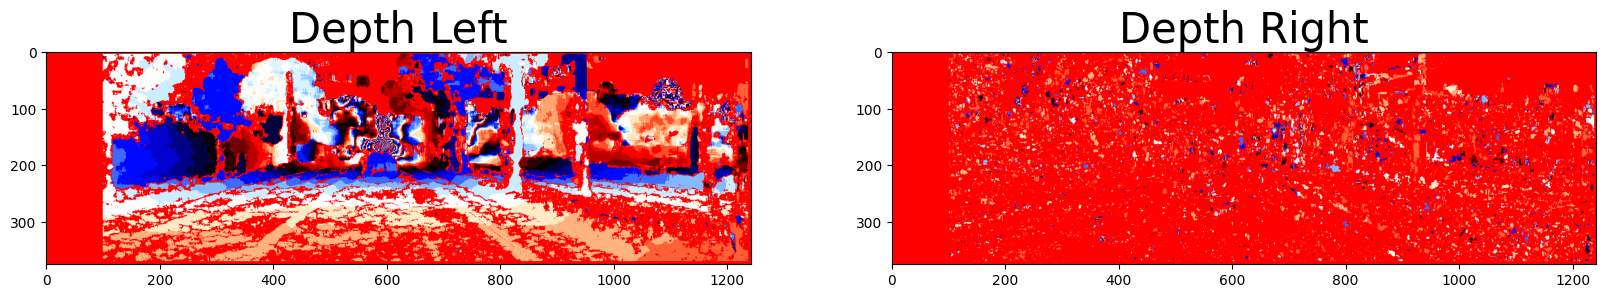

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(depth_map_left,cmap='flag') # cividis/inferno/flag
ax1.set_title('Depth Left', fontsize=30)
ax2.imshow(depth_map_right,cmap='flag') # or flag
ax2.set_title('Depth Right', fontsize=30)

print(depth_map_left.dtype)
print(depth_map_left.shape)
print(depth_map_left[50:150,200:800])
print(disparity_left_img[50:150,200:800])

In [34]:
!mkdir output
np.save('output/depth_map.npy', depth_map_left)

mkdir: cannot create directory ‘output’: File exists


# Outstanding Points 💯
What separates normal folks and those who get outstanding results is the willingness to do the extra 20%. In this case, the extra 20% means going further than your original assignment. It can be:
* By going more in depth inside the algorithms BM/SGBM
* By building a video of your depth map
* By using Deep Learning
* ...? Can you think of a way to do an extra 20%?

The way I like to think about it is, if you're to be a 3D Computer Vision expert, shouldn't you, at the very least, have a comparison video of the different types of Stereo Vision algorithms and their outcomes? Shouldn't you, at the very least, have a video going over a depth map?

I am going to show you two of the ways you can do this... and then — I invite you to continue in your squad!

## **Build a Depth Map Video**

In [81]:
def pipeline_video(img_left, img_right, p_left, p_right, idx):
    "For a pair of 2 Calibrated Images"

    ##TODO: Fill in the steps to get a depth map video
    disparity = compute_disparity(img_left, img_right, num_disparities=6*16, block_size=11, window_size=6, matcher="stereo_sgbm", show_disparity=False)
    k_left, r_left, t_left = decompose_projection_matrix(p_left)
    k_right, r_right, t_right = decompose_projection_matrix(p_right)
    depth_map = calc_depth_map(disparity, k_left, t_left, t_right)

    depth_map_img = depth_map / np.max(depth_map) * 255
    depth_map_img = depth_map_img.astype(np.uint8)
    # depth_map_img = cv2.cvtColor(depth_map_img, cv2.COLOR_GRAY2BGR)
    
    return depth_map_img

In [84]:
left_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_03/data/*.png"))

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline_video(left_img, right_img, p_left, p_right,idx))
    print(idx)

/tmp/ipykernel_15310/226237440.py:17: RuntimeWarning: divide by zero encountered in divide
  depth_map[:] =  f * b / disparity #TODO


max =  38.437683 , min =  0.0
0
max =  38.437683 , min =  0.0
1
max =  38.437683 , min =  0.0
2
max =  38.437683 , min =  0.0
3
max =  38.437683 , min =  0.0
4
max =  34.943348 , min =  0.0
5
max =  38.437683 , min =  0.0
6
max =  38.437683 , min =  0.0
7
max =  34.943348 , min =  0.0
8
max =  38.437683 , min =  0.0
9
max =  38.437683 , min =  0.0
10
max =  38.437683 , min =  0.0
11
max =  34.943348 , min =  0.0
12
max =  34.943348 , min =  0.0
13
max =  32.031403 , min =  0.0
14
max =  34.943348 , min =  0.0
15
max =  32.031403 , min =  0.0
16
max =  38.437683 , min =  0.0
17
max =  38.437683 , min =  0.0
18
max =  38.437683 , min =  0.0
19
max =  34.943348 , min =  0.0
20
max =  32.031403 , min =  0.0
21
max =  34.943348 , min =  0.0
22
max =  38.437683 , min =  0.0
23
max =  34.943348 , min =  0.0
24
max =  38.437683 , min =  0.0
25
max =  34.943348 , min =  0.0
26
max =  38.437683 , min =  0.0
27
max =  38.437683 , min =  0.0
28
max =  38.437683 , min =  0.0
29
max =  42.708534 , m

In [85]:
(h,w) = result_video[0].shape
print(np.max(result_video[0]), np.min(result_video[0]))
os.makedirs('./output/2011_09_26_drive_0017_sync/', exist_ok=True)
out = cv2.VideoWriter('output/2011_09_30_drive_0016_sync.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    result = cv2.imwrite("output/2011_09_26_drive_0017_sync/"+str(i).zfill(5)+".png",result_video[i])
    if not result:
        print("Failed to save the image.")
    
    frame_3ch = cv2.cvtColor(result_video[i], cv2.COLOR_GRAY2BGR)
    out.write(frame_3ch)
    print(i)
out.release()

255 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


In [88]:
left_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/*.png"))
#left_video = glob.glob("data/video/left/*.png")
#right_video = glob.glob("data/video/right/*.png")

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline(left_img, right_img, p_left, p_right, idx))
    print(idx)

(w,h,_) = left_img.shape
out = cv2.VideoWriter('output/out0005.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

## **Deep Learning Based Depth Estimation**

In [87]:
!git clone https://github.com/nianticlabs/monodepth2.git
!cd monodepth2

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180 (from 1)
Receiving objects: 100% (180/180), 10.27 MiB | 14.44 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [91]:
import sys
sys.path.append('/content/stereo_data/monodepth2')

In [92]:
input_image = cv2.imread("/content/stereo_data/left/000009.png")

input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

input_image.shape[:2]

[ WARN:0@14040.399] global loadsave.cpp:275 findDecoder imread_('/content/stereo_data/left/000009.png'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import cv2
import numpy as np
import torch
from monodepth2.networks import DepthDecoder, ResnetEncoder
from monodepth2.utils import download_model_if_doesnt_exist
from google.colab.patches import cv2_imshow

# Download the model weights
model_name = "mono_640x192"
download_model_if_doesnt_exist(model_name)

# Load the model components
encoder_path = f"/content/stereo_data/models/{model_name}/encoder.pth"
depth_decoder_path = f"/content/stereo_data/models/{model_name}/depth.pth"

# Load the encoder
encoder = #TODO: Define a Resnet Encoder)
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

# Load the depth decoder
depth_decoder = #TODO: Define a Depth Decoder
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

# Set to evaluation mode
encoder.eval()
depth_decoder.eval()

# Read and preprocess an image
input_image = cv2.imread("/content/stereo_data/left/000009.png")

input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
original_height, original_width = input_image.shape[:2]
input_image = cv2.resize(input_image, (640, 192))
input_image = input_image.transpose(2, 0, 1)
input_image = np.expand_dims(input_image, 0)
input_image = torch.from_numpy(input_image).float() / 255.0

# Predict depth
with torch.no_grad():
    features = #TODO: Go through the encoder
    outputs = #TODO: Go through the decoder

# Generate the depth map
disp = #TODO: Show the output
disp_resized = torch.nn.functional.interpolate(disp, (original_height, original_width), mode="bilinear", align_corners=False)

# Saving numpy file
depth_map = disp_resized.squeeze().cpu().numpy()
np.save("depth_map.npy", depth_map)

# Visualize the result
disp_resized_np = disp_resized.squeeze().cpu().numpy()
cv2_imshow(disp_resized_np)


In [ ]:
print(disp_resized_np*255)

In [ ]:
print(np.min(disp_resized_np))

In [ ]:
plt.imshow(disp_resized_np*255, cmap="magma")
plt.show()

In [ ]:
print(np.max(np.load('depth_map.npy')))

In [ ]:
test_depth = calc_depth_map(disp_resized_np, k_left, t_left, t_right)

In [ ]:
print((test_depth))

In [ ]:
plt.imshow(test_depth, cmap="magma")